In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import folium
from tqdm import tqdm

# Caso 1

Caso 1: Optimización de rutas para los pedidos del último mes disponible Utilizar los datos actuales de clientes, vehículos y pedidos para planificar las rutas de entrega, minimizando el coste total y maximizando el número de entregas realizadas dentro de las restricciones de capacidad, autonomía y vehículos disponibles.

### 1º Algoritmo optimización: hill climbing

In [2]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_location.xlsx"
df_location = pd.read_excel(path_df_location)

path_df_vehicle = "../dataset/df_vehicle.xlsx"
df_vehicle = pd.read_excel(path_df_vehicle)

path_df_orders = "../dataset/df_orders.xlsx"
df_orders = pd.read_excel(path_df_orders)

path_df_distance_km = "../dataset/df_distance_km.xlsx"
df_distance_km = pd.read_excel(path_df_distance_km)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/df_location.xlsx'

In [ ]:
# Crear Lista de Clientes y Validación
# Lista de clientes más el almacén al inicio y al final
clientes = ['Almacén'] + df_location['Cliente'].tolist() + ['Almacén']

# Validar pedidos individuales antes de asignarlos a vehículos
def validate_clients(orders, vehicles):
    for index, row in orders.iterrows():
        if row['order_demand'] > vehicles['capacidad_kg'].max():
            print(f"El cliente {row['cliente']} tiene una demanda que excede la capacidad de todos los vehículos.")
            return False
    return True

if not validate_clients(df_orders, df_vehicle):
    raise ValueError("Existen pedidos que no pueden ser atendidos por ningún vehículo.")

Definición de Funciones Auxiliares


In [ ]:
# Función para calcular el costo de una ruta considerando restricciones de carga y autonomía
def calculate_cost(route, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    total_distance = 0
    total_load = 0
    total_cost = 0

    for i in range(len(route) - 1):
        segment_distance = distances.loc[route[i], route[i+1]]

        if segment_distance == 0 or total_distance + segment_distance > vehicle_range:
            return float('inf')  # Ruta no viable por autonomía

        total_distance += segment_distance

        if route[i] != 'Almacén':  # Ignorar el almacén para la carga
            order_row = orders.loc[orders['cliente'] == route[i], 'order_demand']
            if not order_row.empty:
                total_load += order_row.iloc[0]

        if total_load > vehicle_capacity:
            return float('inf')  # Ruta no viable por carga

        total_cost += segment_distance * vehicle_cost_km

    return total_cost

# Función para generar una solución inicial aleatoria
def generate_initial_solution(clientes):
    solution = clientes[:]
    random.shuffle(solution)
    return solution

# Función para obtener vecinos intercambiando dos elementos de la ruta
def get_neighbors(route):
    neighbors = []
    if len(route) > 2:  # Asegura que hay más de un cliente además del almacén
        for i in range(1, len(route)-1):
            for j in range(i + 1, len(route)-1):
                new_route = route[:]
                new_route[i], new_route[j] = new_route[j], new_route[i]
                neighbors.append(new_route)
    return neighbors if neighbors else [route]  # Retorna la ruta actual si no hay vecinos

# Función principal del algoritmo Hill Climbing
def hill_climbing(clientes, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    current_solution = generate_initial_solution(clientes)
    current_cost = calculate_cost(current_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
    
    while True:
        neighbors = get_neighbors(current_solution)
        if not neighbors:
            print("No hay vecinos posibles, terminando la optimización.")
            break
        
        next_solution = min(neighbors, key=lambda r: calculate_cost(r, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km))
        next_cost = calculate_cost(next_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
        
        if next_cost >= current_cost:
            break
        
        current_solution, current_cost = next_solution, next_cost
    
    return current_solution, current_cost




In [ ]:
# Calcular el costo total de todas las subrutas de un vehículo
def calculate_total_cost(subroutes, distances, vehicle_cost_km):
    total_cost = 0
    for subroute in subroutes:
        subroute_cost = 0
        for i in range(len(subroute) - 1):
            segment_distance = distances.loc[subroute[i], subroute[i + 1]]
            if segment_distance == 0.0:  # Conexión inválida
                print(f"Error: Distancia inválida entre {subroute[i]} y {subroute[i + 1]}.")
                return float('inf')  # Ruta inválida
            subroute_cost += segment_distance * vehicle_cost_km
        total_cost += subroute_cost
    return total_cost

In [ ]:
# Dividir rutas basadas en restricciones de capacidad y autonomía
def split_route_by_constraints(route, distances, orders, vehicle_capacity, vehicle_range):
    subroutes = []
    current_subroute = ['Almacén']
    current_load = 0
    current_distance = 0

    for cliente in route:
        if cliente == 'Almacén':
            continue  # Ignorar el almacén dentro de la lógica
        order_demand = orders.loc[orders['cliente'] == cliente, 'order_demand'].iloc[0]
        last_stop = current_subroute[-1]
        segment_distance = distances.loc[last_stop, cliente]

        # Verificar si se exceden las restricciones de carga o autonomía
        if (current_load + order_demand > vehicle_capacity or
                current_distance + segment_distance > vehicle_range):
            # Cierra la subruta y empieza una nueva
            current_subroute.append('Almacén')
            subroutes.append(current_subroute)
            current_subroute = ['Almacén', cliente]
            current_load = order_demand
            current_distance = distances.loc['Almacén', cliente]
        else:
            current_subroute.append(cliente)
            current_load += order_demand
            current_distance += segment_distance

    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    subroutes.append(current_subroute)

    return subroutes


# Corregir subrutas con conexiones inválidas
def correct_invalid_subroutes(subroute, distances):
    corrected_subroutes = []
    current_subroute = ['Almacén']
    
    for i in range(1, len(subroute)):
        segment_distance = distances.loc[subroute[i - 1], subroute[i]]
        
        if segment_distance == 0.0:  # Conexión inválida
            print(f"Error: Distancia inválida entre {subroute[i - 1]} y {subroute[i]}. Dividiendo la subruta.")
            current_subroute.append('Almacén')
            corrected_subroutes.append(current_subroute)
            current_subroute = ['Almacén', subroute[i]]
        else:
            current_subroute.append(subroute[i])
    
    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    corrected_subroutes.append(current_subroute)
    
    return corrected_subroutes




In [ ]:
# Agrupamiento de clientes usando K-Means
num_vehicles = len(df_vehicle)
kmeans = KMeans(n_clusters=num_vehicles, random_state=42, n_init=10)
df_location['cluster'] = kmeans.fit_predict(df_location[['Latitud', 'Longitud']])

vehicle_routes = {}
vehicle_costs = {}

for vehicle_id in range(num_vehicles):
    cluster_customers = df_location[df_location['cluster'] == vehicle_id]['Cliente'].tolist() + ['Almacén']
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']

    # Optimización inicial de la ruta
    optimal_route, _ = hill_climbing(
        cluster_customers,
        df_distance_km.set_index('CLIENTES'),
        df_orders,
        vehicle_capacity,
        vehicle_range,
        vehicle_cost_km
    )

    # Corregir conexiones inválidas
    corrected_subroutes = correct_invalid_subroutes(
        optimal_route,
        df_distance_km.set_index('CLIENTES')
    )

    # Dividir cada subruta por restricciones
    final_subroutes = []
    for subroute in corrected_subroutes:
        final_subroutes.extend(
            split_route_by_constraints(
                subroute,
                df_distance_km.set_index('CLIENTES'),
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Calcular el costo total de las subrutas finales
    total_cost = calculate_total_cost(final_subroutes, df_distance_km.set_index('CLIENTES'), vehicle_cost_km)

    vehicle_routes[vehicle_id] = final_subroutes
    vehicle_costs[vehicle_id] = total_cost





Error: Distancia inválida entre Cliente_13 y Cliente_7. Dividiendo la subruta.
Error: Distancia inválida entre Cliente_7 y Cliente_3. Dividiendo la subruta.


In [ ]:
# Identificar clientes no atendidos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_no_atendidos = set(df_orders['cliente']) - entregados

if clientes_no_atendidos:
    print(f"Clientes no atendidos: {clientes_no_atendidos}")
    
    # Redistribuir clientes no atendidos
    for cliente in clientes_no_atendidos:
        reasignado = False
        for vehicle_id, routes in vehicle_routes.items():
            # Verificar capacidad y autonomía disponibles
            vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
            vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
            distances = df_distance_km.set_index('CLIENTES')
            
            # Verificar si el cliente puede ser agregado a alguna subruta existente
            for subroute in routes:
                subroute_cost = calculate_cost(
                    subroute + [cliente, 'Almacén'], distances, df_orders, vehicle_capacity, vehicle_range, vehicle_cost_km
                )
                if subroute_cost < float('inf'):
                    print(f"Reasignando {cliente} al Vehículo {vehicle_id + 1} en subruta existente.")
                    subroute.insert(-1, cliente)  # Insertar el cliente antes del 'Almacén'
                    reasignado = True
                    break
            
            # Si no se reasignó a una subruta existente, crear una nueva subruta
            if not reasignado:
                print(f"Creando nueva subruta para {cliente} en Vehículo {vehicle_id + 1}.")
                vehicle_routes[vehicle_id].append(['Almacén', cliente, 'Almacén'])
                reasignado = True
            
            if reasignado:
                break


Clientes no atendidos: {'Cliente_10', 'Cliente_20', 'Cliente_13'}
Creando nueva subruta para Cliente_10 en Vehículo 1.
Reasignando Cliente_20 al Vehículo 1 en subruta existente.
Creando nueva subruta para Cliente_13 en Vehículo 1.


In [ ]:
print(vehicle_routes)
print(vehicle_costs)	

{0: [['Almacén', 'Cliente_12', 'Cliente_18', 'Almacén'], ['Almacén', 'Cliente_10', 'Cliente_20', 'Almacén'], ['Almacén', 'Cliente_13', 'Almacén']], 1: [['Almacén', 'Cliente_16', 'Cliente_5', 'Cliente_6', 'Cliente_17', 'Almacén'], ['Almacén', 'Cliente_4', 'Cliente_9', 'Cliente_1', 'Cliente_14', 'Almacén'], ['Almacén', 'Cliente_11', 'Almacén']], 2: [['Almacén']], 3: [['Almacén'], ['Almacén', 'Cliente_7', 'Almacén'], ['Almacén', 'Cliente_3', 'Cliente_2', 'Almacén']], 4: [['Almacén', 'Cliente_15', 'Cliente_8', 'Almacén']], 5: [['Almacén', 'Cliente_19', 'Almacén']]}
{0: np.float64(5.730899999999999), 1: np.float64(8.069362), 2: 0, 3: np.float64(9.47682), 4: np.float64(13.584928), 5: np.float64(6.170304000000001)}


In [ ]:
# Identificar vehículos con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]

# Mostrar cuáles vehículos tienen costos infinitos
if problematic_vehicles:
    print(f"Vehículos con costos infinitos: {[v + 1 for v in problematic_vehicles]}")
else:
    print("No hay vehículos con costos infinitos.")


No hay vehículos con costos infinitos.


In [ ]:
# Asegurar que todos los vehículos realicen al menos una entrega
vehicles_without_deliveries = [vid for vid, cost in vehicle_costs.items() if cost == 0]
if vehicles_without_deliveries:
    print(f"Vehículos sin entregas significativas: {[v + 1 for v in vehicles_without_deliveries]}")
    
    for vehicle_id in vehicles_without_deliveries:
        for other_vehicle_id in vehicle_routes:
            if other_vehicle_id != vehicle_id:
                for subroute in vehicle_routes[other_vehicle_id]:
                    for client in subroute:
                        if client != 'Almacén':  # Evitar el almacén
                            print(f"Reasignando {client} al Vehículo {vehicle_id + 1}.")
                            
                            # Crear una nueva subruta para el cliente reasignado
                            vehicle_routes[vehicle_id] = [['Almacén', client, 'Almacén']]
                            
                            # Eliminar cliente de la subruta original
                            subroute.remove(client)
                            
                            # Si la subruta queda vacía, eliminarla
                            if len(subroute) <= 2:
                                vehicle_routes[other_vehicle_id].remove(subroute)
                            
                            # Recalcular el costo para el vehículo
                            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
                            distances = df_distance_km.set_index('CLIENTES')
                            vehicle_costs[vehicle_id] = calculate_total_cost(vehicle_routes[vehicle_id], distances, vehicle_cost_km)
                            break
                    if vehicle_costs[vehicle_id] > 0:
                        break
            if vehicle_costs[vehicle_id] > 0:
                break



Vehículos sin entregas significativas: [3]
Reasignando Cliente_12 al Vehículo 3.


In [ ]:
# Corregir subrutas con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]
for vehicle_id in problematic_vehicles:
    print(f"Corrigiendo subrutas para el Vehículo {vehicle_id + 1}...")
    
    corrected_subroutes = []
    distances = df_distance_km.set_index('CLIENTES')
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']

    for subroute in vehicle_routes[vehicle_id]:
        corrected_subroutes.extend(
            split_route_by_constraints(
                subroute,
                distances,
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Actualizar las subrutas corregidas para el vehículo
    vehicle_routes[vehicle_id] = corrected_subroutes

    # Recalcular el costo total para las subrutas corregidas
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
    total_cost = calculate_total_cost(corrected_subroutes, distances, vehicle_cost_km)
    vehicle_costs[vehicle_id] = total_cost

    print(f"Subrutas Corregidas para el Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(corrected_subroutes, 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print(f"Costo Total Corregido: {total_cost}")



In [ ]:
# Mostrar las rutas óptimas y los costos mínimos para cada vehículo
for vehicle_id in vehicle_routes:
    print(f"Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(vehicle_routes[vehicle_id], 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print("Costo Total:", vehicle_costs[vehicle_id])
    print("\n")


Vehículo 1:
  Subruta 1: Almacén -> Cliente_18 -> Almacén
  Subruta 2: Almacén -> Cliente_10 -> Cliente_20 -> Almacén
  Subruta 3: Almacén -> Cliente_13 -> Almacén
Costo Total: 5.730899999999999


Vehículo 2:
  Subruta 1: Almacén -> Cliente_16 -> Cliente_5 -> Cliente_6 -> Cliente_17 -> Almacén
  Subruta 2: Almacén -> Cliente_4 -> Cliente_9 -> Cliente_1 -> Cliente_14 -> Almacén
  Subruta 3: Almacén -> Cliente_11 -> Almacén
Costo Total: 8.069362


Vehículo 3:
  Subruta 1: Almacén -> Cliente_12 -> Almacén
Costo Total: 4.0949599999999995


Vehículo 4:
  Subruta 1: Almacén
  Subruta 2: Almacén -> Cliente_7 -> Almacén
  Subruta 3: Almacén -> Cliente_3 -> Cliente_2 -> Almacén
Costo Total: 9.47682


Vehículo 5:
  Subruta 1: Almacén -> Cliente_15 -> Cliente_8 -> Almacén
Costo Total: 13.584928


Vehículo 6:
  Subruta 1: Almacén -> Cliente_19 -> Almacén
Costo Total: 6.170304000000001




In [ ]:
# Validar que todos los clientes están cubiertos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_pendientes = set(df_orders['cliente']) - entregados

if clientes_pendientes:
    print(f"Clientes no atendidos: {clientes_pendientes}")
else:
    print("Todos los clientes están atendidos.")

# Validar restricciones de capacidad y autonomía
for vehicle_id, routes in vehicle_routes.items():
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    distances = df_distance_km.set_index('CLIENTES')
    
    for subroute in routes:
        carga_total = sum(df_orders.loc[df_orders['cliente'] == client, 'order_demand'].iloc[0] for client in subroute if client != 'Almacén')
        distancia_total = sum(distances.loc[subroute[i], subroute[i+1]] for i in range(len(subroute)-1))
        
        if carga_total > vehicle_capacity:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su capacidad en la subruta {subroute}.")
        if distancia_total > vehicle_range:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su autonomía en la subruta {subroute}.")


Todos los clientes están atendidos.


Representación Gráfica

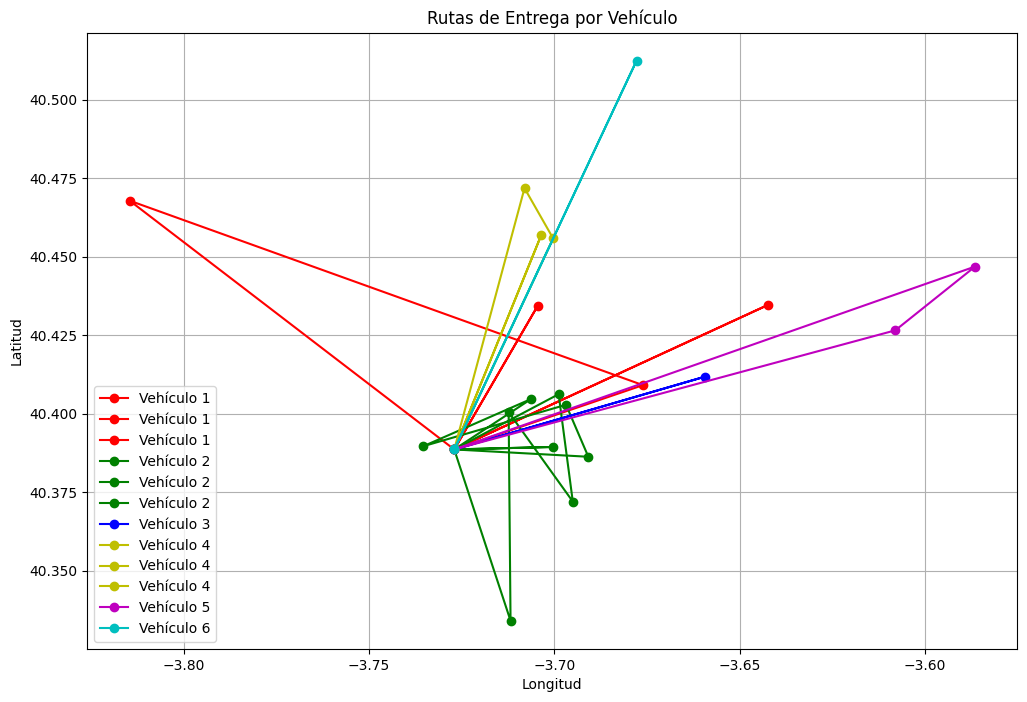

In [ ]:
# Crear representación gráfica de las rutas
def plot_routes(vehicle_routes, df_location):
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'orange', 'purple']

    # Dibujar las rutas de cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        for subroute in routes:
            x_coords = [df_location[df_location['Cliente'] == client]['Longitud'].iloc[0] for client in subroute if client != 'Almacén']
            y_coords = [df_location[df_location['Cliente'] == client]['Latitud'].iloc[0] for client in subroute if client != 'Almacén']
            
            # Agregar las coordenadas del almacén
            x_coords = [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]] + x_coords + [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]]
            y_coords = [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]] + y_coords + [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]]
            
            plt.plot(x_coords, y_coords, marker='o', label=f'Vehículo {vehicle_id + 1}', color=colors[vehicle_id % len(colors)])
    
    # Añadir detalles al gráfico
    plt.title("Rutas de Entrega por Vehículo")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar
plot_routes(vehicle_routes, df_location)


In [ ]:
#Generar Mapas Interactivos	
def generate_route_map(vehicle_routes, df_location):
    # Crear un mapa centrado en la ubicación del almacén
    almacen_coords = df_location[df_location['Cliente'] == 'Almacén'][['Latitud', 'Longitud']].iloc[0]
    route_map = folium.Map(location=[almacen_coords['Latitud'], almacen_coords['Longitud']], zoom_start=12)

    # Colores para las rutas de los vehículos
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen']
    
    # Dibujar rutas para cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        color = colors[vehicle_id % len(colors)]
        for subroute in routes:
            # Coordenadas de los clientes en la subruta
            subroute_coords = [
                (df_location[df_location['Cliente'] == client]['Latitud'].iloc[0], 
                 df_location[df_location['Cliente'] == client]['Longitud'].iloc[0])
                for client in subroute
            ]
            # Añadir la subruta al mapa
            folium.PolyLine(subroute_coords, color=color, weight=5, opacity=0.8).add_to(route_map)
            
            # Añadir marcadores para cada cliente en la subruta
            for client in subroute:
                client_coords = df_location[df_location['Cliente'] == client][['Latitud', 'Longitud']].iloc[0]
                folium.Marker(
                    location=[client_coords['Latitud'], client_coords['Longitud']],
                    popup=f'{client} (Vehículo {vehicle_id + 1})',
                    icon=folium.Icon(color=color)
                ).add_to(route_map)
    
    # Guardar el mapa en un archivo HTML
    route_map.save("mapa_rutas_hill_climbing.html")
    print("Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.")

# Generar el mapa
generate_route_map(vehicle_routes, df_location)


Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.


## 2º Algoritmo optimización: tabu search

In [ ]:
df_distance_km = "../dataset/df_distance_km.xlsx"
df = pd.read_excel(df_distance_km)
df.head()

In [ ]:
df_clientes = df["CLIENTES"]
df_clientes

In [ ]:
#eliminamos la columna CLIENTES
df = df.drop(columns=["CLIENTES"])
distance_km_array = df.to_numpy()
distance_km_array

In [ ]:
# Cargar datos de vehículos
df_vehicle = pd.read_excel('../dataset/df_vehicle.xlsx')
df_vehicle.head()

In [ ]:
# Crear lista de diccionarios con información de cada vehículo
vehiculos = df_vehicle.to_dict('records')  # Convierte cada fila en un diccionario
vehiculos

In [ ]:
# Cargar datos de órdenes
df_orders = pd.read_excel('../dataset/df_orders.xlsx')
df_orders.head()

In [ ]:
# Convertir el número de cliente a entero para ordenar correctamente
df_orders['cliente_num'] = df_orders['cliente'].str.extract('(\d+)').astype(int)

# Ordenar por el número del cliente
df_orders = df_orders.sort_values(by='cliente_num')

df_orders

In [ ]:
# Generar la lista de demandas
demandas = [0]  # La primera posición corresponde al almacén con demanda 0
demandas += df_orders['order_demand'].tolist()

# Mostrar resultados
demandas

In [ ]:
# Función para calcular el costo y validar restricciones
def calcular_costo_y_validar(rutas, matriz_distancias, vehiculos, demandas):
    """
    Calcula el costo total de las rutas y valida restricciones:
    - Capacidad de los vehículos.
    - Autonomía de los vehículos.
    - Costo por kilómetro de cada vehículo.
    Si alguna restricción no se cumple, devuelve un costo infinito.
    """
    costo_total = 0
    for i, ruta in enumerate(rutas):
        capacidad_usada = 0
        distancia_total = 0

        for j in range(len(ruta) - 1):
            origen = ruta[j]
            destino = ruta[j + 1]

            # Validar si la ruta es posible
            distancia = matriz_distancias[origen][destino]
            if distancia == 0:  # Si no hay conexión entre nodos
                return float('inf')

            # Sumar distancia y demanda
            distancia_total += distancia
            capacidad_usada += demandas[destino] if destino > 0 else 0  # No cuenta el almacén

        # Validar restricciones de vehículo
        if capacidad_usada > vehiculos[i]["capacidad_kg"] or distancia_total > vehiculos[i]["autonomia_km"]:
            return float('inf')

        # Calcular costo de la ruta: Distancia total * Costo por kilómetro
        costo_total += distancia_total * vehiculos[i]["costo_km"]

    return costo_total

# Generar solución inicial (garantizando que cada vehículo visite al menos un cliente)
def generar_solucion_inicial(num_vehiculos, num_ubicaciones, demandas, vehiculos):
    """
    Genera una solución inicial asegurando que cada vehículo visite al menos un cliente.
    """
    rutas = [[] for _ in range(num_vehiculos)]
    ubicaciones = list(range(1, num_ubicaciones))  # Excluye el depósito (0)
    random.shuffle(ubicaciones)  # Mezcla las ubicaciones aleatoriamente

    # Asegurar que todos los vehículos visiten al menos un cliente
    for i in range(num_vehiculos):
        if ubicaciones:
            rutas[i].append(ubicaciones.pop())

    # Asignar el resto de ubicaciones respetando las capacidades de los vehículos
    for loc in ubicaciones:
        for i in range(num_vehiculos):
            demanda_total = sum(demandas[nodo] for nodo in rutas[i]) + demandas[loc]
            if demanda_total <= vehiculos[i]["capacidad_kg"]:
                rutas[i].append(loc)
                break

    # Añadir el depósito al inicio y al final de cada ruta
    for ruta in rutas:
        ruta.insert(0, 20)  # Añade el depósito al inicio
        ruta.append(20)    # Añade el depósito al final

    return rutas




# Generar vecinos (movimiento por intercambio)
def generar_vecinos(rutas, matriz_distancias, vehiculos, demandas):
    vecinos = []
    for i in range(len(rutas)):
        for j in range(1, len(rutas[i]) - 1):  # Evitar intercambiar depósitos
            for k in range(j + 1, len(rutas[i]) - 1):
                nueva_ruta = rutas[i][:]  # Copia la ruta actual
                nueva_ruta[j], nueva_ruta[k] = nueva_ruta[k], nueva_ruta[j]  # Intercambia dos ubicaciones
                nueva_solucion = rutas[:]
                nueva_solucion[i] = nueva_ruta

                # Validar restricciones antes de añadir
                if calcular_costo_y_validar(nueva_solucion, matriz_distancias, vehiculos, demandas) != float('inf'):
                    vecinos.append(nueva_solucion)

    return vecinos

# Algoritmo Tabu Search
def tabu_search(matriz_distancias, num_vehiculos, num_ubicaciones, demandas, vehiculos, iteraciones=100, tabu_tam=10):
    """
    Implementa el algoritmo Tabu Search para minimizar el costo bajo restricciones.
    """
    # 1. Solución inicial
    solucion_actual = generar_solucion_inicial(num_vehiculos, num_ubicaciones, demandas, vehiculos)
    
    # Validar si la solución inicial es válida
    if not solucion_actual:
        return [], float('inf')  # Si no se encuentra una solución válida, retornar inf

    mejor_solucion = solucion_actual
    mejor_costo = calcular_costo_y_validar(mejor_solucion, matriz_distancias, vehiculos, demandas)
    
    # Lista Tabú
    lista_tabu = []
    
    for _ in range(iteraciones):
        # 2. Generar vecinos de la solución actual
        vecinos = generar_vecinos(solucion_actual, matriz_distancias, vehiculos, demandas)
        
        # 3. Eliminar soluciones en la lista Tabú
        vecinos = [v for v in vecinos if v not in lista_tabu]
        
        # 4. Seleccionar el mejor vecino
        if vecinos:
            mejor_vecino = min(vecinos, key=lambda v: calcular_costo_y_validar(v, matriz_distancias, vehiculos, demandas))
            costo_vecino = calcular_costo_y_validar(mejor_vecino, matriz_distancias, vehiculos, demandas)
        else:
            break  # No hay vecinos válidos
        
        # 5. Actualizar la mejor solución global si mejora
        if costo_vecino < mejor_costo:
            mejor_solucion = mejor_vecino
            mejor_costo = costo_vecino
        
        # 6. Actualizar la lista Tabú
        lista_tabu.append(solucion_actual)
        if len(lista_tabu) > tabu_tam:  # Mantener el tamaño fijo de la lista Tabú
            lista_tabu.pop(0)
        
        # 7. Moverse al mejor vecino
        solucion_actual = mejor_vecino
    
    return mejor_solucion, mejor_costo

In [ ]:
def imprimir_resultado(rutas, demandas, vehiculos, matriz_distancias):
    """
    Imprime los resultados de la solución con detalles como la ruta, distancia total,
    tiempo total, carga total y el costo por kilómetro de cada vehículo.
    """
    costo_total = 0
    lista_diccionarios_rutas = []
    for i, ruta in enumerate(rutas):
        capacidad_usada = 0
        distancia_total = 0
        tiempo_total = 0
        diccionario_ruta = {"vehiculo" : i, "ruta" : ruta}
        # Mostrar información del vehículo
        print(f"Vehículo {i + 1}:")
        print(f"  Costo por km: {vehiculos[i]['costo_km']} €/km")
        print(f"  Ruta: {ruta}")
        lista_diccionarios_rutas.append(diccionario_ruta)
        for j in range(len(ruta) - 1):
            origen = ruta[j]
            destino = ruta[j + 1]

            # Calcular distancia y demanda
            distancia = matriz_distancias[origen][destino]
            distancia_total += distancia
            capacidad_usada += demandas[destino] if destino > 0 else 0  # No cuenta el almacén

            # Suponemos que 1 km = 1 minuto como estimación
            tiempo_total += distancia

        # Mostrar restricciones de carga y distancia
        print(f"  Distancia total: {distancia_total:.2f} km (Máxima permitida: {vehiculos[i]['autonomia_km']} km)")
        print(f"  Tiempo total: {tiempo_total:.2f} minutos")
        print(f"  Carga total: {capacidad_usada:.2f} kg (Máxima permitida: {vehiculos[i]['capacidad_kg']} kg)")

        # Calcular costo de la ruta
        costo_ruta = distancia_total * vehiculos[i]["costo_km"]
        costo_total += costo_ruta

        print(f"  Costo de la ruta: {costo_ruta:.2f} €")
        print()

    print(f"Costo total: {costo_total:.2f} €")
    return lista_diccionarios_rutas


In [ ]:
# Ejemplo de uso
matriz_distancias = distance_km_array  # Distancias entre ubicaciones
num_vehiculos = len(vehiculos)  # Número de vehículos
num_ubicaciones = len(demandas)  # Número de ubicaciones (incluyendo el depósito)

# Ejecutar Tabu Search
mejor_ruta, mejor_costo = tabu_search(matriz_distancias, num_vehiculos, num_ubicaciones, demandas, vehiculos)

# Imprimir resultados detallados
if mejor_ruta:
    lista_diccionarios_rutas = imprimir_resultado(mejor_ruta, demandas, vehiculos, matriz_distancias)
else:
    print("No se encontró una solución válida.")

In [ ]:
df_locations = pd.read_excel("../dataset/df_location.xlsx")
df_locations

In [ ]:
for elemento in lista_diccionarios_rutas:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones


df_rutas_elementos = pd.DataFrame(lista_diccionarios_rutas)
df_rutas_elementos

In [ ]:

# Crear el mapa base centrado en las coordenadas medias de las rutas
coordenadas = [coord for ruta in df_rutas_elementos['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes_tabu_search.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m

## 3º Algoritmo optimización: genetico

In [ ]:
df_distance_km = "../dataset/df_distance_km.xlsx"
df = pd.read_excel(df_distance_km)
df.head()

In [ ]:
df_clientes = df["CLIENTES"]
df_clientes

In [ ]:
df = df.drop(columns=["CLIENTES"])
distance_km_array = df.to_numpy()
distance_km_array

In [ ]:
df_vehiculos = pd.read_excel("../dataset/df_vehicle.xlsx")
df_vehiculos

In [ ]:
df_time = pd.read_excel("../dataset/df_distance_min.xlsx")

#df_time= df_time.drop(columns=["CLIENTES"])
df_time_array = df.to_numpy()
df_time_array

In [ ]:
df_pedidos = pd.read_excel("../dataset/df_orders.xlsx")
df_pedidos

In [ ]:

def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        carga_total = 0
        
        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            carga_total += pedido_size

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        # Calcular el costo de la ruta (suponiendo un costo por kilómetro y un costo fijo por ruta)
        costo_por_km = df_vehiculos.loc[i, 'costo_por_km'] if 'costo_por_km' in df_vehiculos.columns else 1.0  # Costo por km, asumiendo 1.0 si no está definido
        costo_fijo = df_vehiculos.loc[i, 'costo_fijo'] if 'costo_fijo' in df_vehiculos.columns else 10.0  # Costo fijo por ruta, asumiendo 10.0 si no está definido
        ruta_cost = (ruta_distance * costo_por_km) + costo_fijo

        total_distance += ruta_distance
        total_cost += ruta_cost

    # Asegúrate de retornar una tupla de dos valores
    return (total_distance + penalty, total_cost)

def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]  # Recompone la ruta


In [ ]:

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación



for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos.iloc[:len(df_vehiculos)//2].reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

for elemento in lista_rutas:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones
lista_rutas

df_rutas_elementos2 = pd.DataFrame(lista_rutas)
df_rutas_elementos2

In [ ]:


# Crear el mapa base centrado en las coordenadas medias de las rutas
coordenadas = [coord for ruta in df_rutas_elementos['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m

# Caso 2

Reducción de la flota a la mitad. Se va a usar el algoritmo genético puesto que es el que mejor resultados a dado.

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos.iloc[:len(df_vehiculos)//2].reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos_mitad_flota))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos_mitad_flota))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos_mitad_flota)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        carga_total = 0
        
        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            carga_total += pedido_size

        if ruta_distance > df_vehiculos_mitad_flota.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos_mitad_flota.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']) * 10

        # Calcular el costo de la ruta (suponiendo un costo por kilómetro y un costo fijo por ruta)
        costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_por_km'] if 'costo_por_km' in df_vehiculos_mitad_flota.columns else 1.0  # Costo por km, asumiendo 1.0 si no está definido
        costo_fijo = df_vehiculos_mitad_flota.loc[i, 'costo_fijo'] if 'costo_fijo' in df_vehiculos_mitad_flota.columns else 10.0  # Costo fijo por ruta, asumiendo 10.0 si no está definido
        ruta_cost = (ruta_distance * costo_por_km) + costo_fijo

        total_distance += ruta_distance
        total_cost += ruta_cost

    # Asegúrate de retornar una tupla de dos valores
    return (total_distance + penalty, total_cost)


def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    if size > 1:  # Solo si hay más de un punto para cruzar
        p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce
        child1, child2 = ruta1[:], ruta2[:]

        # Intercambiar segmentos
        child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]
    else:
        # Si hay 1 o menos puntos, no se puede hacer un cruce, así que clonamos las rutas sin cambios
        child1, child2 = ruta1[:], ruta2[:]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]  # Recompone la ruta


creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

from tqdm import tqdm

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos_mitad_flota.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

No es posible realizar todos los envíos con la mitad de la flota sin tener que pasar por el almacén. Se va a probar obteniendo los vehiculos de la flota con mayor capadidad.

## Prueba algoritmo con los vehiculos de la flota con mayor capacidad.

In [ ]:
df_vehiculos_mitad_flota = df_vehiculos_mitad_flota.nlargest(3, 'capacidad_kg').reset_index(drop=True)
df_vehiculos_mitad_flota

In [ ]:

creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))  # Minimizar distancia y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=100)
    
ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

from tqdm import tqdm

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))
    
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    fits = [ind.fitness.values for ind in population]
    
    min_dist = min(f[0] for f in fits)
    min_cost = min(f[1] for f in fits)
    #print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Costo Min = {min_cost}")

best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas = []
total_cost = 0
for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    carga_total = 0
    
    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
    
    costo_por_km = df_vehiculos_mitad_flota.loc[i, 'costo_km'] if 'costo_km' in df_vehiculos_mitad_flota.columns else 1.0
    ruta_cost = (ruta_distance * costo_por_km)
    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'autonomia_km']} km)")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos_mitad_flota.loc[i, 'capacidad_kg']})")
    print(f"  Costo de la ruta: {ruta_cost:.2f}")
    diccionario = {"vehiculo": i, "ruta": ruta, "costo": ruta_cost}
    lista_rutas.append(diccionario)

print(f"\nCosto total: {total_cost:.2f}")

Pese a haber seleccionado los vehiculos de la flota con la mayor capacidad no es posible realizar el envío de todos los paquetes a los clientes sin tener que pasar por el alamacén a recargar paquetes. 

# Caso 4
Para el caso 4 hemos decidido añadir la variable tiempo al algoritmo genético para hacer un analisis de como se modificarían las rutas para poder realizar el envio intentando reducir tanto costes como tiempo.


In [ ]:
def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_time = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        ruta_time = 0
        carga_total = 0
        vehicle_cost_per_km = df_vehiculos.loc[i, 'costo_km']  # Costo por kilómetro del vehículo

        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                time = df_time_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError as e:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            ruta_time += time
            carga_total += pedido_size

        # Calcular costo de la ruta
        ruta_cost = ruta_distance * vehicle_cost_per_km
        total_cost += ruta_cost

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        total_distance += ruta_distance
        total_time += ruta_time

    # Asegúrate de retornar una tupla de tres valores
    return (total_distance + penalty, total_time, total_cost)

def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]],  # Recompone la ruta


In [ ]:

##CASO 4 CON VARIABLE TIEMPO
# Crear tipos personalizados en DEAP
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))  # Minimizar distancia, tiempo y costo
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Definición de la función para generar individuos
def create_individual():
    puntos = list(range(len(distance_km_array) - 1))  # Excluye el último cliente (almacén)
    random.shuffle(puntos)  # Mezcla los puntos
    rutas = [[] for _ in range(len(df_vehiculos))]  # Una ruta por vehículo
    pedidos_asignados = {i: 0 for i in range(len(df_vehiculos))}  # Capacidad usada por cada vehículo

    # Garantizar que cada vehículo tenga al menos un cliente
    for i in range(len(df_vehiculos)):
        if puntos:
            punto = puntos.pop()  # Asigna un punto a este vehículo
            pedido_size = df_pedidos.loc[punto, 'order_demand']
            if pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size

    # Asignar los puntos restantes
    for punto in puntos:
        pedido_size = df_pedidos.loc[punto, 'order_demand']  # Tamaño del pedido
        for i, capacidad_usada in pedidos_asignados.items():
            if capacidad_usada + pedido_size <= df_vehiculos.loc[i, 'capacidad_kg']:
                rutas[i].append(punto)
                pedidos_asignados[i] += pedido_size
                break

    # Agregar inicio y fin (almacén) a cada ruta
    for ruta in rutas:
        ruta.insert(0, ultimo_cliente)  # Inicio (almacén)
        ruta.append(ultimo_cliente)  # Fin (almacén)

    return rutas

# Función para evaluar un individuo
def evaluate(individual):
    total_distance = 0
    total_time = 0
    total_cost = 0
    penalty = 0

    for i, ruta in enumerate(individual):
        ruta_distance = 0
        ruta_time = 0
        ruta_cost = 0
        carga_total = 0

        for j in range(len(ruta) - 1):
            city_a = ruta[j]
            city_b = ruta[j + 1]

            try:
                distance = distance_km_array[city_a][city_b]
                time = df_time_array[city_a][city_b]
                pedido_size = df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
            except IndexError:
                penalty += 1000
                continue

            if distance == 0:
                penalty += 1000
                continue

            ruta_distance += distance
            ruta_time += time
            carga_total += pedido_size
            ruta_cost += distance * df_vehiculos.loc[i, 'costo_km']

        if ruta_distance > df_vehiculos.loc[i, 'autonomia_km']:
            penalty += (ruta_distance - df_vehiculos.loc[i, 'autonomia_km']) * 10
        if carga_total > df_vehiculos.loc[i, 'capacidad_kg']:
            penalty += (carga_total - df_vehiculos.loc[i, 'capacidad_kg']) * 10

        total_distance += ruta_distance
        total_time += ruta_time
        total_cost += ruta_cost

    return (total_distance + penalty, total_time, total_cost)

# Operadores genéticos
def crossover_individuals(ind1, ind2):
    ruta1 = ind1[1:-1]  # Intermedios de ind1
    ruta2 = ind2[1:-1]  # Intermedios de ind2

    size = len(ruta1)
    p1, p2 = sorted(random.sample(range(size), 2))  # Dos puntos de cruce

    child1, child2 = ruta1[:], ruta2[:]

    # Intercambiar segmentos
    child1[p1:p2], child2[p1:p2] = ruta2[p1:p2], ruta1[p1:p2]

    # Recombinar las rutas
    return [ind1[0]] + child1 + [ind1[-1]], [ind2[0]] + child2 + [ind2[-1]]

def mutate_individual(individual):
    ruta_intermedia = individual[1:-1]  # Excluye el primer y último punto
    random.shuffle(ruta_intermedia)  # Mezcla los puntos intermedios
    return [individual[0]] + ruta_intermedia + [individual[-1]]

# Configuración de DEAP
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -10, 10)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", crossover_individuals)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo evolutivo
ultimo_cliente = len(distance_km_array) - 1
population = toolbox.population(n=200)

ngen = 200  # Número de generaciones
cxpb = 0.7  # Probabilidad de cruce
mutpb = 0.2  # Probabilidad de mutación

for gen in tqdm(range(ngen)):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring

    fits = [ind.fitness.values for ind in population]

    min_dist = min(f[0] for f in fits)
    min_time = min(f[1] for f in fits)
    min_cost = min(f[2] for f in fits)
    # print(f"Generación {gen + 1}: Distancia Min = {min_dist}, Tiempo Min = {min_time}, Costo Min = {min_cost}")

# Mostrar la mejor solución
best_ind = tools.selBest(population, 1)[0]
print("\nMejor solución encontrada:")
lista_rutas2 = []
total_cost = 0

for i, ruta in enumerate(best_ind):
    ruta_distance = 0
    ruta_time = 0
    ruta_cost = 0
    carga_total = 0

    for j in range(len(ruta) - 1):
        city_a = ruta[j]
        city_b = ruta[j + 1]
        ruta_distance += distance_km_array[city_a][city_b]
        ruta_time += df_time_array[city_a][city_b]
        carga_total += df_pedidos.loc[city_b, 'order_demand'] if city_b != ultimo_cliente else 0
        ruta_cost += distance_km_array[city_a][city_b] * df_vehiculos.loc[i, 'costo_km']

    total_cost += ruta_cost

    print(f"Vehículo {i + 1}:")
    print(f"  Ruta: {ruta}")
    print(f"  Distancia total: {ruta_distance:.2f} km (Máxima permitida: {df_vehiculos.loc[i, 'autonomia_km']} km)")
    print(f"  Tiempo total: {ruta_time:.2f} minutos")
    print(f"  Carga total: {carga_total:.2f} (Máxima permitida: {df_vehiculos.loc[i, 'capacidad_kg']})")
    print(f"  Costo total: {ruta_cost:.2f} (Costo por km: {df_vehiculos.loc[i, 'costo_km']})")
    diccionario = {"vehiculo" : i, "ruta" : ruta}
    lista_rutas2.append(diccionario)

print(f"\nCosto total de la solución: {total_cost:.2f}")


In [ ]:
df_locations = pd.read_excel("../dataset/df_location.xlsx")
df_locations

In [ ]:

for elemento in lista_rutas2:
    lista_rutas_tuplas_localizaciones = []
    for rut in elemento['ruta']:
        latitud = df_locations.loc[rut, 'Latitud']
        longitud = df_locations.loc[rut, 'Longitud']
        lista_rutas_tuplas_localizaciones.append((latitud, longitud))
    elemento['ruta'] = lista_rutas_tuplas_localizaciones
lista_rutas2

df_rutas_elementos2 = pd.DataFrame(lista_rutas2)
df_rutas_elementos2

In [ ]:
coordenadas = [coord for ruta in df_rutas_elementos2['ruta'] for coord in ruta]
latitudes = [lat for lat, lon in coordenadas]
longitudes = [lon for lat, lon in coordenadas]

m = folium.Map(location=[sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)], zoom_start=14)

# Función para calcular un punto intermedio
def punto_intermedio(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return (lat1 + lat2) / 2, (lon1 + lon2) / 2

# Crear capas para cada vehículo
for _, row in df_rutas_elementos2.iterrows():
    vehiculo = row['vehiculo']
    ruta = row['ruta']
    
    # Crear una FeatureGroup para cada vehículo
    feature_group = folium.FeatureGroup(name=f'Ruta {vehiculo}')
    
    # Añadir la línea que conecta los puntos de la ruta
    folium.PolyLine(ruta, color='blue', weight=2.5, opacity=1).add_to(feature_group)
    
    # Añadir flechas en los segmentos de la ruta
    for i in range(len(ruta) - 1):
        punto_inicio = ruta[i]
        punto_fin = ruta[i + 1]
        intermedio = punto_intermedio(punto_inicio, punto_fin)
        
        # Añadir una flecha en el punto intermedio
        folium.Marker(
            location=intermedio,
            icon=folium.DivIcon(html="""<div style="transform: rotate(-45deg); font-size: 16px;">→</div>"""),
            tooltip=f'Flecha {vehiculo}'
        ).add_to(feature_group)
    df_locations
    # Añadir marcadores en los puntos de la ruta con el cliente y el orden de visita
    for idx, (lat, lon) in enumerate(ruta, start=1):
        # Buscar el cliente correspondiente en df_clientes
        cliente = df_locations[
            (df_locations['Latitud'] == lat) & 
            (df_locations['Longitud'] == lon)
        ]['Cliente'].values[0]
        
        folium.Marker(
            location=[lat, lon],
            tooltip=f'{vehiculo} - {cliente} - Orden: {idx}',  # Orden de visita y cliente
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12px; color: black; text-align: center;">
                    <strong>{idx}</strong>
                </div>""")  # Mostrar el número del orden
        ).add_to(feature_group)
    
    # Añadir la ruta al mapa
    feature_group.add_to(m)

# Añadir un control de capas para las pestañas
folium.LayerControl().add_to(m)

# Guardar el mapa en un archivo HTML
m.save("mapa_con_flechas_y_clientes_tiempo.html")

# Mostrar el mapa (si estás en Jupyter Notebook)
m